In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_dq import dq_report, dc_report
from scipy.stats import chi2_contingency
from scipy.stats import skew, kurtosis


import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import shap
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
import optuna
from optuna.trial import TrialState
import joblib

In [91]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

I decided to keep every step of the modeling process inside a single notebook, for this reason, the number of imported libraries and the size of this file are going to be a bit inflated, but I hope to make life easier for the reader. Functions will be defined as they are about to be used, in order to facilitate referencing.

# Import Data

In [92]:
air_systems_previous = pd.read_csv("../../data/raw/air_system_previous_years.csv")
air_systems_present = pd.read_csv("../../data/raw/air_system_present_year.csv")

In [93]:
air_systems_previous.replace("na", np.nan, inplace=True)
air_systems_previous["class"].replace({"neg": 0, "pos": 1}, inplace=True)
air_systems_previous = air_systems_previous.astype("float64")

air_systems_present.replace("na", np.nan, inplace=True)
air_systems_present["class"].replace({"neg": 0, "pos": 1}, inplace=True)
air_systems_present = air_systems_present.astype("float64")

# Looking for Data drift
We were given two distinct datasets. There's an implicit understanding that we are dealing with temporal data. To be safe, let's see if there is any significant difference in the variables' distributions between the two datasets. Our analysis is impaired by the fact that we don't actually have the time index.

In [94]:
ks_results = []

for col in air_systems_previous.columns:
    # Perform KS test for each column
    statistic, p_value = ks_2samp(
        air_systems_previous[col].dropna(), air_systems_present[col].dropna()
    )
    ks_results.append({"Column": col, "Statistic": statistic, "p_value": p_value})

ks_results_air_systems_previous = pd.DataFrame(ks_results)

We are conducting a significance test for each variable. Conventionally, we reject the null hypothesis (there is no observed difference) when p < 0.05 or 0.01. All of our p-values are higher than the threshold, so we won't be rejecting the null hypothesis and we can conclude with some degree of confidence that there are no statistically significant differences between the datasets. Still, there are some edge cases. We could explore these more with confidence intervals. Since the original data is temporal, we could check for heteroskedasticity and other measures of the changing nature of time data. For now, we will accept that both sets come from the same underlying distribution.

In [95]:
ks_results_air_systems_previous.sort_values(by="p_value").T

,88,71,41,86,87,143,129,80,69,55,151,124,49,107,57,4,60,148,131,63,104,79,82,83,112,108,105,115,118,1,11,44,54,58,97,158,125,150,157,160,23,114,21,149,78,3,59,167,25,26,156,45,22,81,133,17,68,89,84,48,24,134,47,165,116,12,159,163,85,106,43,66,56,95,40,162,120,46,103,161,132,144,164,145,122,102,101,117,119,153,126,18,13,32,2,128,73,70,38,166,110,10,152,93,15,67,0,53,64,77,62,127,99,31,14,74,16,121,91,72,111,146,61,98,75,147,76,29,65,19,168,137,9,39,109,100,138,50,96,92,136,6,8,5,51,155,27,42,135,37,28,94,113,90,20,7,30,154,123,33,34,35,36,130,52,142,141,140,139,169,170
Column,cb_000,bj_000,ay_008,bz_000,ca_000,dn_000,cz_000,bs_000,bh_000,ba_002,dv_000,ct_000,az_006,cn_007,ba_004,ad_000,ba_007,ds_000,db_000,bb_000,cn_004,br_000,bu_000,bv_000,cq_000,cn_008,cn_005,cs_001,cs_004,aa_000,ag_004,az_001,ba_001,ba_005,ck_000,ed_000,cu_000,du_000,ec_00,ee_001,an_000,cs_000,al_000,dt_000,bq_000,ac_000,ba_006,ee_008,ap_000,aq_000,eb_000,az_002,am_0,bt_000,dd_000,ah_000,bg_000,cc_000,bx_000,az_005,ao_000,de_000,az_004,ee_006,cs_002,ag_005,ee_000,ee_004,by_000,cn_006,az_000,be_000,ba_003,ci_000,ay_007,ee_003,cs_006,az_003,cn_003,ee_002,dc_000,do_000,ee_005,dp_000,cs_008,cn_002,cn_001,cs_003,cs_005,dy_000,cv_000,ai_000,ag_006,ax_000,ab_000,cy_000,bl_000,bi_000,ay_005,ee_007,co_000,ag_003,dx_000,cg_000,ag_008,bf_000,class,ba_000,bc_000,bp_000,ba_009,cx_000,cm_000,av_000,ag_007,bm_000,ag_009,cs_007,ce_000,bk_000,cp_000,dq_000,ba_008,cl_000,bn_000,dr_000,bo_000,at_000,bd_000,aj_000,ee_009,dh_000,ag_002,ay_006,cn_009,cn_000,di_000,az_007,cj_000,cf_000,dg_000,af_000,ag_001,ae_000,az_008,ea_000,ar_000,ay_009,df_000,ay_004,as_000,ch_000,cr_000,cd_000,ak_000,ag_000,au_000,dz_000,cs_009,ay_000,ay_001,ay_002,ay_003,da_000,az_009,dm_000,dl_000,dk_000,dj_000,ef_000,eg_000
Statistic,0.011972,0.011837,0.01184,0.011385,0.011536,0.01091,0.012359,0.010788,0.010743,0.010506,0.010611,0.011789,0.010355,0.010279,0.010268,0.011769,0.010214,0.010244,0.011251,0.009751,0.009709,0.022702,0.009678,0.009678,0.009678,0.009579,0.009494,0.009441,0.009422,0.009367,0.009394,0.009391,0.009389,0.009384,0.009343,0.010108,0.010512,0.009414,0.010058,0.0092,0.009166,0.009153,0.009109,0.009277,0.020786,0.009265,0.008989,0.008971,0.00896,0.008956,0.009216,0.008935,0.008892,0.008827,0.008959,0.008794,0.008768,0.008881,0.008843,0.008624,0.008563,0.008713,0.008536,0.008529,0.008527,0.008434,0.008406,0.008394,0.008283,0.008285,0.008268,0.008352,0.008153,0.007971,0.007975,0.007946,0.007931,0.007931,0.007931,0.007929,0.008968,0.008021,0.007827,0.007936,0.007766,0.007749,0.007725,0.00772,0.007676,0.007803,0.008687,0.007553,0.007447,0.007451,0.015203,0.008156,0.009651,0.007182,0.007141,0.00713,0.008139,0.006879,0.007004,0.007875,0.006823,0.006931,0.006771,0.006779,0.006827,0.014494,0.006531,0.007387,0.007014,0.006476,0.006258,0.010479,0.006136,0.005968,0.0059,0.007272,0.005834,0.005777,0.005667,0.006105,0.010717,0.005662,0.01117,0.005332,0.005369,0.005193,0.005033,0.004713,0.004112,0.004025,0.004003,0.003925,0.003227,0.002961,0.002914,0.003262,0.002808,0.002697,0.002634,0.002657,0.002555,0.002325,0.002242,0.00208,0.001897,0.0017,0.000265,0.000028,0.001619,0.0,0.000621,0.000761,0.000194,0.000639,0.001124,0.001437,0.001417,0.001201,0.001077,0.001507,0.000974,0.000331,0.000315,0.000797,0.000591,0.000335,0.000299
p_value,0.055539,0.059654,0.059944,0.08762,0.088449,0.101652,0.102362,0.108844,0.110937,0.126276,0.132068,0.133745,0.136545,0.142081,0.142834,0.143031,0.146898,0.15884,0.170158,0.184552,0.188809,0.19059,0.191545,0.191545,0.191545,0.20103,0.209273,0.214376,0.216312,0.216342,0.219209,0.219605,0.219806,0.220307,0.221454,0.223981,0.232318,0.235054,0.235588,0.239889,0.242948,0.245026,0.249349,0.249907,0.251521,0.256832,0.263963,0.266047,0.266667,0.266844,0.268387,0.270342,0.274652,0.27804,0.284495,0.287056,0.290073,0.300911,0.305735,0.309489,0.316512,0.318478,0.32116,0.322208,0.322309,0.335056,0.339176,0.340785,0.353697,0.356457,0.358837,0.365809,0.376009,0.399872,0.403197,0.407713,0.409963

# Split the data
Let's consider 'air_systems_previous' to be our train set. We wil further split it into train and evaluation sets.

In [96]:
X_train, X_val, y_train, y_val = train_test_split(
    air_systems_previous.drop(columns="class"),
    air_systems_previous["class"],
    test_size=0.2,
    random_state=42,
)

# General overview of the data

dq_report can be used to quickly check data types, number of unique values and missing values, outliers and other general descriptive characteristics of our dataset.

In [97]:
# dq_report(X_train, verbose=1)

# Comparing NaN distributions
We were told that the presence of NaN values is due to errors in the new database system and we might think that this implies that NaN values are distributed randomly. Here, we will check if this is the case.

In [98]:
train_na_analysis = X_train.isna()
train_na_analysis["class"] = y_train

When grouping by positive and negative classes, we get a strong suggestion that the fraction of NaN values is different between the two classes.

In [99]:
train_na_analysis.groupby(by="class").mean()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.772113,0.047806,0.239981,0.035754,0.035754,0.011501,0.011501,0.011501,0.011501,0.011501,0.011501,0.011501,0.011501,0.011501,0.011501,0.010442,0.010188,0.010188,0.064475,0.010421,0.010188,0.010421,0.009510,0.010421,0.009510,0.038846,0.010188,0.010188,0.010188,0.035732,0.035754,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011755,0.011755,0.011755,0.011755,0.011755,0.011755,0.011755,0.011755,0.011755,0.011755,0.010442,0.038888,0.038910,0.035817,0.035754,0.010421,0.010421,0.009510,0.009510,0.389456,0.462234,0.670169,0.745849,0.786093,0.809180,0.825765,0.834872,0.011755,0.002648,0.011311,0.011311,0.053652,0.008197,0.038846,0.063564,0.011755,0.053588,0.010993,0.035775,0.239981,0.239981,0.239981,0.005698,0.005698,0.005698,0.157651,0.16212,0.011734,0.011734,0.011734,0.011734,0.011734,0.011734,0.011734,0.011734,0.011734,0.011734,0.239981,0.038867,0.011311,0.772113,0.011459,0.011459,0.011459,0.011459,0.011459,0.011459,0.011459,0.011459,0.011459,0.011459,0.224413,0.224413,0.224413,0.224413,0.224413,0.224413,0.224413,0.224413,0.224413,0.035796,0.038867,0.058248,0.058248,0.058248,0.058206,0.058227,0.058227,0.058248,0.058269,0.011311,0.038867,0.038888,0.038888,0.038888,0.038910,0.038910,0.038888,0.038888,0.038846,0.038867,0.038846,0.038846,0.058227,0.167796,0.157651,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.011480,0.038867,0.038846
1.0,0.0,0.775381,0.470812,0.645939,0.355330,0.355330,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.044416,0.044416,0.044416,0.531726,0.046954,0.044416,0.046954,0.043147,0.046954,0.043147,0.397208,0.044416,0.044416,0.044416,0.355330,0.355330,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.005076,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.044416,0.397208,0.397208,0.355330,0.355330,0.046954,0.046954,0.043147,0.043147,0.069797,0.071066,0.073604,0.077411,0.081218,0.086294,0.091371,0.095178,0.048223,0.011421,0.045685,0.045685,0.030457,0.001269,0.397208,0.529188,0.048223,0.030457,0.046954,0.355330,0.645939,0.645939,0.645939,0.010152,0.010152,0.010152,0.232234,0.28934,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.645939,0.397208,0.045685,0.775381,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.003807,0.5

A quick chi-square test will allow us to say with more certainty if those differences are significant. 

In [100]:
p_values = []

# Loop through each column in group_air_systems_previous
for col in train_na_analysis.columns:
    # Create a contingency table
    contingency_table = pd.crosstab(train_na_analysis[col], train_na_analysis["class"])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    p_values.append(p)

p_values_train_na_analysis = pd.DataFrame(
    {"Column": train_na_analysis.columns, "p-value": p_values}
)

Here, many of our p-values are rounded to 0. This means that we can reject the null hypothesis and accept the alternative hypothesis that there are significative differences. For this test, this means that the fraction of null values in one of the classes is significatively greater than what would be expected.

This means that not having a value might actually be informative and not simply due to randomness. A first consequence of that is that if we decide to drop NaN values at some point of our analysis / model training, we may lose information. 

In [101]:
p_values_train_na_analysis.sort_values(by="p-value", ascending=False).T

,0,112,1,94,95,96,42,40,39,38,35,37,36,44,34,33,43,47,45,46,163,48,49,50,51,162,161,160,159,158,32,41,164,167,165,166,116,119,118,117,121,115,114,113,122,120,11,10,6,9,13,12,7,14,15,8,99,100,106,101,102,103,104,105,108,107,57,61,60,59,58,56,55,54,53,52,84,88,83,80,97,157,111,142,82,81,16,62,87,79,17,18,21,27,28,29,89,69,23,25,70,98,24,68,67,20,22,156,71,126,124,125,129,127,128,130,131,123,72,3,109,91,92,93,73,149,143,144,145,146,147,148,168,150,153,151,155,154,152,169,141,85,140,75,2,4,5,19,26,30,31,63,64,65,66,74,76,139,77,78,86,90,110,132,133,134,135,136,137,138,170
Column,aa_000,cr_000,ab_000,ci_000,cj_000,ck_000,az_000,ay_008,ay_007,ay_006,ay_003,ay_005,ay_004,az_002,ay_002,ay_001,az_001,az_005,az_003,az_004,ee_005,az_006,az_007,az_008,az_009,ee_004,ee_003,ee_002,ee_001,ee_000,ay_000,ay_009,ee_006,ee_009,ee_007,ee_008,cs_003,cs_006,cs_005,cs_004,cs_008,cs_002,cs_001,cs_000,cs_009,cs_007,ag_005,ag_004,ag_000,ag_003,ag_007,ag_006,ag_001,ag_008,ag_009,ag_002,cn_000,cn_001,cn_007,cn_002,cn_003,cn_004,cn_005,cn_006,cn_009,cn_008,ba_005,ba_009,ba_008,ba_007,ba_006,ba_004,ba_003,ba_002,ba_001,ba_000,by_000,cc_000,bx_000,bt_000,cl_000,ed_000,cq_000,dn_000,bv_000,bu_000,ah_000,bb_000,cb_000,bs_000,ai_000,aj_000,am_0,as_000,at_000,au_000,cd_000,bi_000,ao_000,aq_000,bj_000,cm_000,ap_000,bh_000,bg_000,al_000,an_000,ec_00,bk_000,cx_000,cu_000,cv_000,da_000,cy_000,cz_000,db_000,dc_000,ct_000,bl_000,ad_000,co_000,cf_000,cg_000,ch_000,bm_000,du_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,ef_000,dv_000,dz_000,dx_000,eb_000,ea_000,dy_000,eg_000,dm_000,bz_000,dl_000,bo_000,ac_000,ae_000,af_000,ak_000,ar_000,av_000,ax_000,bc_000,bd_000,be_000,bf_000,bn_000,bp_000,dk_000,bq_000,br_000,ca_000,ce_000,cp_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,class
p-value,1.0,0.861807,0.861807,0.161472,0.161472,0.161472,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.130566,0.065357,0.065357,0.065357,0.065357,0.065357,0.065357,0.065357,0.065357,0.065357,0.065357,0.064228,0.064228,0.064228,0.064228,0.064228,0.064228,0.064228,0.064228,0.064228,0.064228,0.058357,0.058357,0.058357,0.058357,0.058357,0.058357,0.058357,0.058357,0.058357,0.058357,0.05785,0.05785,0.05785,0.05785,0.05785,0.05785,0.05785,0.05785,0.05785,0.05785,0.050769,0.005285,0.005183,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can visualize it with a plot. The X axis tell us the fraction of nan-values present.

In [102]:
auxiliar_table = train_na_analysis.groupby(by="class").mean().copy()
auxiliar_table = auxiliar_table.transpose().reset_index(drop=True).melt()

<Axes: xlabel='value', ylabel='Count'>

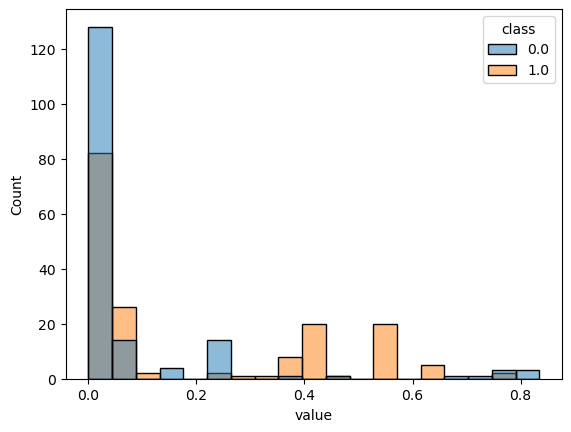

In [103]:
sns.histplot(data=auxiliar_table, hue="class", x="value")

# Measuring long-tailed-ness
We should also be attentive to what does our distributions actually look like. This has many implications, from hypothesis testing to modeling. It is not unusual for a method to assume that the data is normally distributed.

Kurtosis is a measure of how 'long tailed' a random variable is. When the tails are heavy, we will expect extreme values to be much more frequent. For the normal distribution, kurtosis = 3. Any value higher than that will imply larger tails. 

### Categorical variables

We cannot meaningfully measure the kurtosis of a categorical variable. Due to anonymization, improper original data schema and lack of a data dictionary, we cannot know for sure which variables are categorical. But we can try to infer.

In [104]:
X_train.shape

(48000, 170)

In the dataframe below, we are measuring the quantity of unique values per variable. With 48000 values, some of the variables have a very small amount of unique values, which suggests that the variables may be categorical, even if they are high-dimensional.

In [105]:
pd.DataFrame(X_train.nunique()).sort_values(by=0).T

,cd_000,ch_000,as_000,ef_000,ab_000,dz_000,au_000,eg_000,cs_009,ar_000,cr_000,dj_000,ea_000,db_000,ag_000,ak_000,dl_000,dm_000,dk_000,da_000,az_009,ae_000,df_000,ay_009,af_000,ay_000,cf_000,ag_001,cg_000,cy_000,cs_008,ay_001,ay_002,aj_000,ay_003,cl_000,dh_000,bf_000,dg_000,az_008,cn_000,ay_004,co_000,de_000,ad_000,ac_000,cm_000,ag_002,ax_000,cp_000,ct_000,bc_000,cn_009,cs_001,at_000,br_000,cu_000,bd_000,az_007,ai_000,av_000,be_000,bq_000,ed_000,bp_000,cn_001,di_000,ag_009,bo_000,dy_000,dr_000,ba_009,dd_000,bn_000,cj_000,az_001,ag_003,dq_000,al_000,bm_000,az_002,az_000,ee_009,cs_000,cn_008,am_0,cz_000,ba_008,dp_000,az_006,bl_000,bk_000,bs_000,dx_000,cn_002,bz_000,dt_000,cs_007,ag_008,ay_005,do_000,dn_000,az_003,ce_000,cn_007,aa_000,by_000,ag_004,ee_008,ba_007,cx_000,bh_000,ds_000,eb_000,cs_002,du_000,ba_006,ca_000,ba_005,dv_000,ee_007,ba_004,cb_000,ec_00,ee_006,ee_003,ag_007,cn_006,cv_000,ba_003,dc_000,az_004,ay_006,cn_003,ee_002,cs_004,aq_000,ee_004,cs_003,ba_002,ee_005,ay_008,cn_005,ay_007,ee_001,bj_000,ba_001,ag_006,ag_005,cs_006,ee_000,cn_004,bi_000,cs_005,bg_000,ah_000,cc_000,az_005,ba_000,ap_000,ck_000,bt_000,ci_000,ao_000,an_000,bv_000,cq_000,bu_000,bb_000,bx_000
0,1,2,13,22,26,42,45,46,50,59,62,66,121,131,131,138,149,181,213,228,301,302,342,358,371,374,454,514,584,648,736,744,781,794,831,863,933,978,1069,1083,1265,1440,1687,1734,1742,1897,1913,2000,2017,2068,2422,2530,2732,3009,3035,3147,3208,3229,3307,3414,3505,3531,3557,3593,4169,4596,4696,4827,4912,5435,5649,5666,5971,6080,6337,6577,6646,6843,7831,7924,8072,8219,8526,8529,9132,9167,9418,9997,10591,10717,10817,11824,12015,12125,12672,14221,14273,15712,16540,16812,17905,18577,18659,19006,19215,19352,19683,19725,20474,21131,21507,21825,22568,23188,24068,24196,24622,24982,25038,25507,25735,25961,26543,26625,26850,26871,26916,27206,27765,27921,27943,28700,28793,29075,29176,29228,29651,29677,29766,30402,30491,31919,32315,32363,32441,32562,33680,34080,34397,34445,35262,35307,35579,35649,36510,36511,36654,37268,37511,37530,37819,38002,38425,39737,40096,40842,40842,40843,40881,42727


Let's arbitrarely consider <1000 unique values to be categorical.

In [106]:
numerical_columns = pd.DataFrame(X_train.nunique())[
    pd.DataFrame(X_train.nunique())[0] > 1000
].index
categorical_columns = pd.DataFrame(X_train.nunique())[
    pd.DataFrame(X_train.nunique())[0] < 1000
].index

In [107]:
# Function to calculate skewness and kurtosis for each column in the DataFrame
def calculate_skewness_kurtosis(air_systems_previous):
    results = {"Column": [], "Skewness": [], "Kurtosis": []}
    for col in air_systems_previous.columns:
        col_numeric = pd.to_numeric(
            air_systems_previous[col], errors="coerce"
        )  # Convert to numeric, coercing errors to NaN
        results["Column"].append(col)
        results["Skewness"].append(skew(col_numeric.dropna(), nan_policy="omit"))
        results["Kurtosis"].append(kurtosis(col_numeric.dropna(), nan_policy="omit"))
    return pd.DataFrame(results)

In [108]:
calculate_skewness_kurtosis(X_train[numerical_columns]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131
Column,aa_000,ac_000,ad_000,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,at_000,av_000,ax_000,ay_004,ay_005,ay_006,ay_007,ay_008,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,ce_000,ci_000,cj_000,ck_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,ct_000,cu_000,cv_000,cx_000,cz_000,dc_000,dd_000,de_000,dg_000,di_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009
Skewness,6.207878,1.787365,190.152569,37.459875,25.412016,24.479081,9.632333,8.281386,12.621017,34.937682,86.628411,5.589378,48.605123,28.180117,28.415936,5.629217,5.73946,7.871605,7.901475,56.495994,26.4808,16.043305,62.427348,38.214095,13.074773,23.593325,9.696723,67.062223,57.529402,87.443023,34.101962,8.854442,13.770498,27.808998,70.728397,64.43589,12.060127,10.047099,9.528196,9.766351,9.490995,10.05581,10.736039,8.981129,58.113078,53.611222,5.927173,46.748453,24.040833,39.163462,5.590875,6.932378,9.193439,9.809012,3.18738,2.472415,1.600361,1.121943,0.84026,0.648298,0.493236,0.389406,2.009428,6.209045,5.935648,5.935647,6.374941,7.022154,19.902676,0.71762,0.662596,6.421172,8.381656,5.919171,22.819636,8.797472,14.3986,60.719794,28.003987,16.095989,10.83918,9.344505,8.510987,18.460003,29.058816,22.147593,99.332279,190.152569,41.872879,5.935647,15.741079,69.315408,13.742896,11.482072,11.711753,11.781259,16.250532,130.1919,127.466723,34.530189,7.050868,11.466567,58.884617,7.24784,13.779898,38.828362,87.899194,24.445906,8.740395,8.970331,7.306005,35.576226,13.297851,7.402609,7.241399,9.173461,17.342091,11.163607,18.898623,13.499137,9.689336,8.925113,10.77178,12.91815,12.8487,14.307744,18.373435,15.079061,10.1702,16.718848,13.4367,22.519582
Kurtosis,49.733689,1.194673,36155.999593,1807.148208,1247.864903,1720.31928,233.848027,94.581049,264.041357,2025.254934,8933.959715,38.831305,3181.394505,1157.093122,1182.41923,40.218283,42.34547,83.180918,83.780315,3879.928122,1091.656744,416.750324,5051.998977,2090.656048,254.573169,1657.126408,132.733252,6680.26047,5632.865083,9331.657781,1577.711017,115.483335,584.756972,1350.303353,8370.016031,6277.323863,364.727448,215.524111,170.461528,193.636793,174.649632,174.033989,167.038067,121.241822,6143.277823,5698.228245,44.394897,3912.983595,1031.820969,2546.064654,38.899096,66.504279,128.964589,132.839563,9.691718,4.937936,0.974313,-0.461243,-1.06419,-1.373593,-1.565491,-1.667915,6.688237,49.738082,44.596219,44.596213,50.573079,65.827537,691.192786,-0.842251,-0.92383,51.200044,123.580361,44.19736,710.063144,107.28144,305.445309,4854.957429,1134.714961,425.014776,187.986756,192.584002,119.254113,601.856161,1509.946407,613.312556,11115.731045,36155.999711,2116.616836,44.596213,875.224606,8950.051464,270.052843,212.454142,195.909597,445.723183,706.504986,18855.776622,20584.149276,1612.67956,80.432129,196.17624,4086.436122,90.080648,339.912029,2666.166821,10692.597065,753.323253,119.481885,135.556732,98.460351,1464.140774,246.942675,77.681036,77.134983,160.229895,599.143042,170.972235,559.63093,244.429167,127.216448,109.839506,164.397184,253.273197,471.168581,549.031369,998.2

In [109]:
aux_kurtosis = calculate_skewness_kurtosis(X_train[numerical_columns]).sort_values(by="Kurtosis")
aux_kurtosis.reset_index(inplace=True, drop=True)

Let's visualize our kurtosis. Remember, our reference value is 3. That means that we have some extremely long tails (leptokurtic distribution). When kurtosis is too high, measures of central tendency such as the mean or the median are less meaningful. Getting rid of outliers will also be a more complicated matter - what is an outlier when extreme values are much more probable? In fact, what even is an extreme value?

Is it possible it may have something to do with the way the data was anonymized?

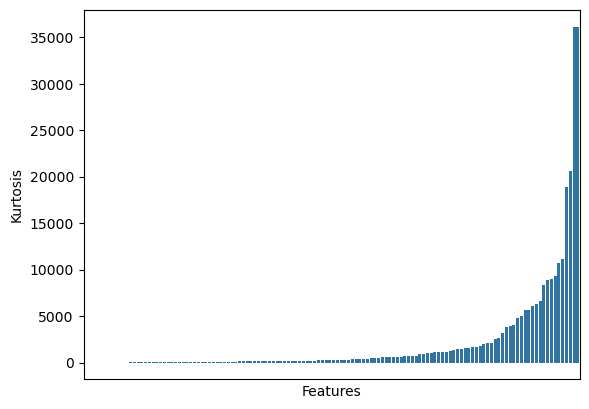

In [110]:
fig = plt.figure
sns.barplot(data=aux_kurtosis, x=aux_kurtosis.index, y="Kurtosis")
plt.xticks(ticks=[])
plt.xlabel("Features")
plt.show()

# Droping columns with more than 20% NaNs

As we have seen before, some of the columns are missing many values. We will be droping those with more than 20% NaNs.

In [111]:
X_train.dropna(axis=1, thresh=(len(X_train) * 0.8), inplace=True)
X_val.dropna(axis=1, thresh=(len(X_val) * 0.8), inplace=True)

In [112]:
X_train.shape

(48000, 146)

# Imputing NaN's

This is no easy task. More art than science. Imputing the median is a default policy that may be problematic even if our distributions were normal. Knowing what the variables actually are may be helpful. We could use some sophisticated method, like training random forests to imput values that might make more sense than the median. This will add complexity and more uncertainty to our model. For this proof-of-concept, we will go with a simple median imputer.

In [113]:
# from missforest.missforest import MissForest
#  # default estimators are lgbm classifier and regressor
# mf = MissForest()
# mf.fit(
#         X_train,
#         categorical=categorical_columns
#     )
# train_imputed = mf.transform(X_train)
# test_imputed = mf.transform(X_val)
# print(test_imputed)

(This is the main reason I split the data before transforming it. Imputing values this away could cause some form of leakage)

In [114]:
for col in X_train.columns:
    X_train[col].fillna(X_train[col].median(), inplace=True)
for col in X_val.columns:
    X_val[col].fillna(X_val[col].median(), inplace=True)

Add random noise column. This will help me selecting relevant features later.

In [115]:
np.random.seed(42)
X_train["random_noise"] = np.random.normal(loc=0.0, scale=1.0, size=len(X_train))

np.random.seed(42)
X_val["random_noise"] = np.random.normal(loc=0.0, scale=1.0, size=len(X_val))

I will scale the data to improve performance on gradiant based algorithms. 

In [116]:
scaler = StandardScaler()
scaled_train_data = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaled_val_data = pd.DataFrame(scaler.fit_transform(X_val), columns=X_train.columns)

I used a general purpose environment for this project and ended up having a problem with the mrmr_selection package. Due to time constraint, we will be using another method of feature selection for now. 

In [27]:
# # select top 10 features using mRMR
# selected_features = mrmr_classif(X_train, y_train, K=50)

# Comparing Models

In [101]:
# Note: The dataset is very unbalanced, not adpating some of the algorithms to this fact may lead worse results.
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "CatBoosting": CatBoostClassifier(silent=True),
    "Support Vector Machine": SVC(class_weight="balanced"),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(is_unbalance=True, verbose=-1),
    "Neural Network": MLPClassifier(max_iter=10000),
}

In [72]:
f1_scorer = make_scorer(f1_score, average="binary", zero_division=0)

In [67]:
def evaluate_classifiers(clf, X, y, cv_splits=5):
    scores = cross_val_score(clf, X, y, cv=cv_splits, scoring=f1_scorer)
    return scores

In [69]:
results = {}

for clf_name, clf in tqdm.tqdm(classifiers.items(), desc="Evaluating classifiers"):
    f1_scores = evaluate_classifiers(clf, scaled_train_data, y_train)
    results[clf_name] = f1_scores

Evaluating classifiers: 100%|██████████| 9/9 [07:45<00:00, 51.74s/it]


In [70]:
results

{'Logistic Regression': array([0.55642023, 0.5465587 , 0.55905512, 0.55795678, 0.54545455]),
 'Decision Tree': array([0.66881029, 0.55921053, 0.60714286, 0.61093248, 0.61935484]),
 'Random Forest': array([0.66666667, 0.6147541 , 0.66403162, 0.69767442, 0.71538462]),
 'CatBoosting': array([0.82562278, 0.77256318, 0.80952381, 0.77931034, 0.79322034]),
 'Support Vector Machine': array([0.7037037 , 0.67539267, 0.7037037 , 0.66161616, 0.68542199]),
 'K-Nearest Neighbors': array([0.64341085, 0.62686567, 0.6124031 , 0.609375  , 0.61302682]),
 'Naive Bayes': array([0.4835924 , 0.47942755, 0.47712418, 0.44126984, 0.43478261]),
 'LightGBM': array([0.78823529, 0.7607362 , 0.79289941, 0.75449102, 0.82492582]),
 'Neural Network': array([0.78472222, 0.74496644, 0.76923077, 0.74496644, 0.76872964])}

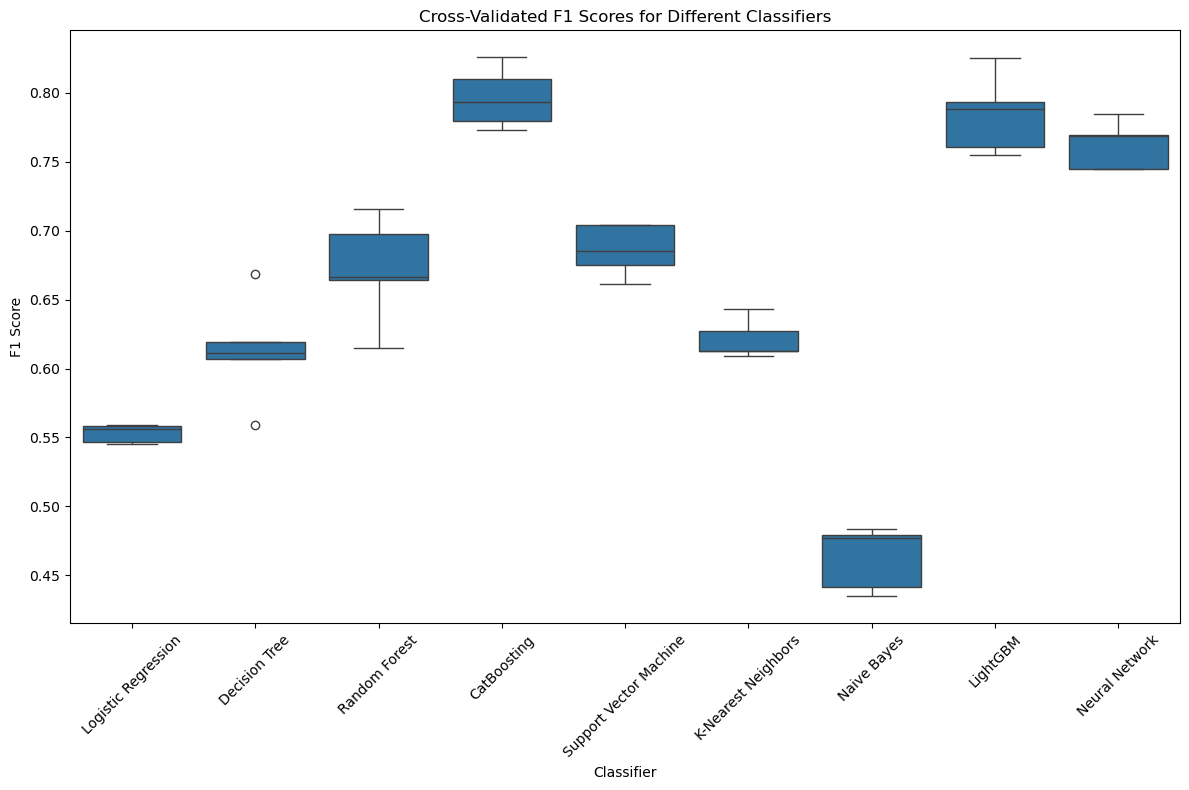

In [71]:
results_air_systems_previous = pd.DataFrame(results)
results_melted = results_air_systems_previous.melt(var_name="Classifier", value_name="F1 Score")

plt.figure(figsize=(12, 8))
sns.boxplot(x="Classifier", y="F1 Score", data=results_melted)
plt.title("Cross-Validated F1 Scores for Different Classifiers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Baseline CatBoostClassifier

In [68]:
cat_boost = CatBoostClassifier(silent=True, random_seed=42)
cat_boost.fit(scaled_train_data, y_train)

This is our baseline eval score (0.766). We will try to improve on that by selectiong features and tuning the parameters.

In [69]:
f1_score(y_val, cat_boost.predict(scaled_val_data))

0.7668393782383419

# Feature Selection with Permutation Importance

In [118]:
result = permutation_importance(
    cat_boost,
    scaled_val_data,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=2,
    scoring=f1_scorer,
)

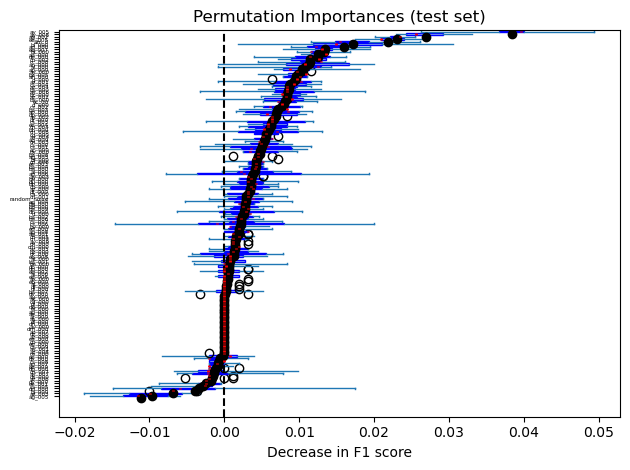

In [130]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=scaled_val_data.columns[sorted_importances_idx],
)

# Plot permutation importances
fig, ax = plt.subplots()
importances.plot.box(
    vert=False,
    whis=10,
    ax=ax,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="black", markeredgecolor="black"),
)

# Adding a mean line
for i in range(importances.shape[1]):
    mean_value = importances.iloc[:, i].mean()
    ax.plot(mean_value, i, "o", color="black")

ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in F1 score")
ax.tick_params(axis="y", labelsize=4)
ax.figure.tight_layout()

plt.show()

We will exclude all features that performed worse than the random noise column.

In [131]:
importances["random_noise"].mean()

0.0028355399177074194

In [133]:
((importances.mean() > importances["random_noise"].mean()) == True).index

Index(['ag_005', 'az_003', 'bj_000', 'dd_000', 'cs_005', 'ee_001', 'dy_000',
       'az_006', 'ds_000', 'ay_007',
       ...
       'aa_000', 'bt_000', 'ee_007', 'aq_000', 'bi_000', 'am_0', 'ee_005',
       'ag_002', 'ay_008', 'ay_005'],
      dtype='object', length=147)

In [195]:
important_features_series = pd.Series((importances.mean() > importances["random_noise"].mean()))
important_features_series[important_features_series == True].index

Index(['bx_000', 'az_007', 'cs_005', 'cn_002', 'ee_009', 'bs_000', 'bv_000',
       'dr_000', 'ca_000', 'by_000', 'ba_000', 'am_0', 'cs_006', 'ba_006',
       'al_000', 'cs_001', 'cc_000', 'bt_000', 'ee_005', 'cj_000', 'ay_002',
       'ag_007', 'ac_000', 'aa_000', 'ay_007', 'ai_000', 'ay_000', 'ay_008',
       'ag_002', 'ay_005'],
      dtype='object')

In [134]:
important_features_series = pd.Series((importances.mean() > importances["random_noise"].mean()))
important_features_series[important_features_series == True].index

Index(['cn_001', 'ca_000', 'dt_000', 'az_000', 'cb_000', 'bb_000', 'du_000',
       'bu_000', 'ay_003', 'ag_006', 'ai_000', 'ba_000', 'ba_004', 'ee_003',
       'cn_006', 'bf_000', 'ag_003', 'ba_008', 'by_000', 'ac_000', 'cs_001',
       'cs_000', 'cn_003', 'ag_009', 'ay_004', 'cq_000', 'cn_008', 'bh_000',
       'cn_004', 'ee_004', 'cs_003', 'dr_000', 'ay_002', 'dp_000', 'ao_000',
       'ba_003', 'cs_002', 'cl_000', 'ec_00', 'bx_000', 'az_002', 'bc_000',
       'ay_006', 'bs_000', 'az_004', 'cs_004', 'az_001', 'cj_000', 'ah_000',
       'ba_005', 'ay_000', 'ap_000', 'al_000', 'an_000', 'cc_000', 'cn_002',
       'de_000', 'aa_000', 'bt_000', 'ee_007', 'aq_000', 'bi_000', 'am_0',
       'ee_005', 'ag_002', 'ay_008', 'ay_005'],
      dtype='object')

In [107]:
important_columns = [
    "bx_000",
    "az_007",
    "cs_005",
    "cn_002",
    "ee_009",
    "bs_000",
    "bv_000",
    "dr_000",
    "ca_000",
    "by_000",
    "ba_000",
    "am_0",
    "cs_006",
    "ba_006",
    "al_000",
    "cs_001",
    "cc_000",
    "bt_000",
    "ee_005",
    "cj_000",
    "ay_002",
    "ag_007",
    "ac_000",
    "aa_000",
    "ay_007",
    "ai_000",
    "ay_000",
    "ay_008",
    "ag_002",
    "ay_005",
]

In [135]:
important_columns = [
    "cn_001",
    "ca_000",
    "dt_000",
    "az_000",
    "cb_000",
    "bb_000",
    "du_000",
    "bu_000",
    "ay_003",
    "ag_006",
    "ai_000",
    "ba_000",
    "ba_004",
    "ee_003",
    "cn_006",
    "bf_000",
    "ag_003",
    "ba_008",
    "by_000",
    "ac_000",
    "cs_001",
    "cs_000",
    "cn_003",
    "ag_009",
    "ay_004",
    "cq_000",
    "cn_008",
    "bh_000",
    "cn_004",
    "ee_004",
    "cs_003",
    "dr_000",
    "ay_002",
    "dp_000",
    "ao_000",
    "ba_003",
    "cs_002",
    "cl_000",
    "ec_00",
    "bx_000",
    "az_002",
    "bc_000",
    "ay_006",
    "bs_000",
    "az_004",
    "cs_004",
    "az_001",
    "cj_000",
    "ah_000",
    "ba_005",
    "ay_000",
    "ap_000",
    "al_000",
    "an_000",
    "cc_000",
    "cn_002",
    "de_000",
    "aa_000",
    "bt_000",
    "ee_007",
    "aq_000",
    "bi_000",
    "am_0",
    "ee_005",
    "ag_002",
    "ay_008",
    "ay_005",
]

# Filtered Catboost

Let's try a new CatBoost model with less features.

In [176]:
filtered_x_train = X_train[important_columns]
filtered_x_val = X_val[important_columns]

Train

In [174]:
filtered_cat_boost = CatBoostClassifier(silent=True, random_seed=42)
filtered_cat_boost.fit(filtered_x_train, y_train)
# Auto_class_weights didn't improve performance

Scoring

In [177]:
f1_score(y_val, filtered_cat_boost.predict(filtered_x_val))

0.8041237113402062

Text(0.5, 1.0, 'Confusion Matrix')

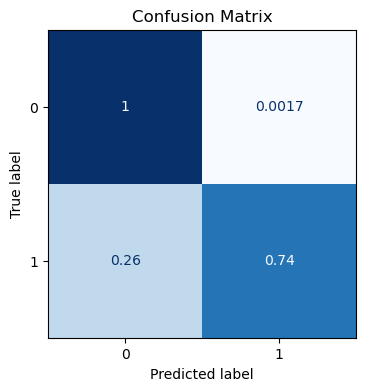

In [138]:
cm1 = confusion_matrix(y_val, filtered_cat_boost.predict(X_val), normalize="true")

fig, axes = plt.subplots(1, figsize=(10, 4))


disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap=plt.cm.Blues, ax=axes, colorbar=False)
axes.set_title("Confusion Matrix")

In [139]:
print(classification_report(y_val, filtered_cat_boost.predict(X_val)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     11788
         1.0       0.89      0.74      0.80       212

    accuracy                           0.99     12000
   macro avg       0.94      0.87      0.90     12000
weighted avg       0.99      0.99      0.99     12000



In [212]:
filtered_x_train

,cn_001,ca_000,dt_000,az_000,cb_000,bb_000,du_000,bu_000,ay_003,ag_006,ai_000,ba_000,ba_004,ee_003,cn_006,bf_000,ag_003,ba_008,by_000,ac_000,cs_001,cs_000,cn_003,ag_009,ay_004,cq_000,cn_008,bh_000,cn_004,ee_004,cs_003,dr_000,ay_002,dp_000,ao_000,ba_003,cs_002,cl_000,ec_00,bx_000,az_002,bc_000,ay_006,bs_000,az_004,cs_004,az_001,cj_000,ah_000,ba_005,ay_000,ap_000,al_000,an_000,cc_000,cn_002,de_000,aa_000,bt_000,ee_007,aq_000,bi_000,am_0,ee_005,ag_002,ay_008,ay_005
48572,0.0,3732.0,18.0,98.0,37700.0,37822.0,10260.0,37822.0,0.0,2956.0,0.0,3344.0,180.0,64.0,6.0,0.0,0.0,10.0,23.0,2.200000e+01,12.0,1030.0,1272.0,0.0,0.0,37822.0,0.0,126.0,2714.0,104.0,16.0,0.0,0.0,0.0,4912.0,94.0,18.0,2.0,0.76,39494.0,84.0,0.0,0.0,31280.0,128.0,346.0,58.0,286.08,606.0,108.0,0.0,31398.0,0.0,6408.0,4934.0,0.0,96.0,18.0,17.96,0.0,492.0,29982.0,0.0,154.0,0.0,3922.0,0.0
38696,0.0,1882.0,50.0,52.0,19620.0,19714.0,520.0,19714.0,0.0,3442.0,0.0,6030.0,32.0,82.0,0.0,0.0,0.0,0.0,17.0,4.200000e+01,10.0,68.0,3722.0,0.0,0.0,19714.0,0.0,200.0,3834.0,102.0,268.0,0.0,0.0,0.0,5016.0,66.0,12.0,0.0,43.32,25582.0,10.0,4.0,7742.0,12100.0,180.0,506.0,6.0,0.00,3058.0,18.0,0.0,12224.0,0.0,7478.0,7742.0,0.0,40.0,30.0,29.51,0.0,1182.0,9554.0,0.0,6.0,0.0,0.0,0.0
13611,0.0,1464.0,8.0,54.0,15400.0,15694.0,4260.0,15694.0,0.0,2666.0,0.0,4494.0,50.0,34.0,0.0,0.0,0.0,48.0,26.0,8.000000e+00,14.0,1002.0,1998.0,0.0,0.0,15694.0,0.0,172.0,2698.0,56.0,490.0,326.0,0.0,0.0,1362.0,76.0,22.0,0.0,39.78,18518.0,14.0,0.0,0.0,11600.0,2132.0,878.0,24.0,0.00,2244.0,40.0,0.0,11826.0,0.0,3840.0,5838.0,0.0,56.0,14.0,14.89,140.0,594.0,8964.0,0.0,40.0,0.0,1630.0,0.0
35213,0.0,29676.0,7720.0,1896.0,339940.0,2765966.0,5918140.0,2765966.0,0.0,1576904.0,0.0,730362.0,151310.0,174792.0,556158.0,8.0,0.0,0.0,15560.0,2.130706e+09,514.0,4128.0,9170.0,762.0,0.0,2765966.0,3706.0,35044.0,622800.0,401068.0,149994.0,0.0,0.0,18530.0,1850766.0,196866.0,39514.0,2.0,1151.76,2747986.0,1562.0,146.0,1635998.0,59040.0,19490.0,92446.0,1122.0,0.00,1148192.0,116578.0,0.0,540964.0,0.0,2224436.0,2584872.0,0.0,692.0,41650.0,41649.02,166102.0,308850.0,285514.0,0.0,438100.0,0.0,2.0,0.0
31766,0.0,15326.0,25102.0,4858.0,200900.0,3842892.0,6744000.0,3842892.0,0.0,2658314.0,0.0,1327796.0,265362.0,126844.0,239066.0,44.0,0.0,0.0,16756.0,0.000000e+00,1252.0,11302.0,26928.0,0.0,0.0,3842892.0,8502.0,65688.0,1774208.0,334944.0,230464.0,0.0,0.0,10864.0,2858838.0,311850.0,7164.0,0.0,1917.24,3847850.0,1678.0,0.0,3541556.0,26980.0,2757030.0,211810.0,594.0,0.00,1894584.0,254824.0,0.0,556526.0,0.0,3284840.0,3697996.0,0.0,178.0,59684.0,59683.47,469092.0,331914.0,295606.0,0.0,483618.0,0.0,1324.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,0.0,27146.0,21966.0,3486.0,329820.0,5176604.0,2689060.0,5176604.0,0.0,3241100.0,3370.0,2266932.0,199208.0,123142.0,1626718.0,0.0,0.0,75186.0,31754.0,2.120000e+03,784.0,5402.0,2316.0,0.0,0.0,5176604.0,8838.0,84302.0,427730.0,73606.0,817488.0,0.0,0.0,2434.0,2548008.0,240230.0,24414.0,0.0,2180.98,5169806.0,1178.0,0.0,101976.0,85460.0,3665200.0,649664.0,958.0,74280.00,2094208.0,181428.0,0.0,1509246.0,0.0,3666640.0,4821014.0,0.0,486.0,29690.0,29690.11,1360.0,1035174.0,653684.0,0.0,17098.0,0.0,6.0,0.0
38158,0.0,1882.0,48.0,1028.0,19880.0,20040.0,4840.0,20040.0,0.0,5300.0,0.0,7890.0,30.0,70.0,0.0,0.0,0.0,14.0,24.0,8.200000e+01,14.0,1026.0,2692.0,0.0,0.0,20040.0,0.0,224.0,5902.0,68.0,932.0,222.0,0.0,0.0,7792.0,234.0,32.0,0.0,754.36,20652.0,32.0,0.0,0.0,9500.0,414.0,52.0,36.0,0.00,4280.0,34.0,0.0,9710.0,0.0,10312.0,9592.0,0.0,40.0,6.0,5.02,4.0,868.0,6784.0,0.0,38.0,0.0,9592.0,0.0
860,0.0,45250.0,22740.0,3018.0,488760.0,2913766.0,1739000.0,2913766.0,0.0,1970378.0,0.0,1232010.0,124750.0,212524.0,314060.0,8.0,0.0,24.0,18477.0,1.880000e+02,558.0,4034.0,21534.0,768.0,0.0,2913766.0,4148.0,51306.0,817

# Optuna

We will be introducing a new metric here, Total Cost. We will try to optimize with respect to this metric. Each combination of hyperparameters will be cross-validated on the train set.

In [ ]:
# f1_scorer = make_scorer(f1_score, average="binary", zero_division=0)

In [10]:
# def objective(trial):
#     param = {
#         "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
#         "depth": trial.suggest_int("depth", 1, 12),
#         "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "bootstrap_type": trial.suggest_categorical(
#             "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#         ),
#         "used_ram_limit": "3gb",
#         "eval_metric": "Accuracy",
#     }

#     if param["bootstrap_type"] == "Bayesian":
#         param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     elif param["bootstrap_type"] == "Bernoulli":
#         param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

#     # Initialize CatBoostClassifier with parameters
#     model = CatBoostClassifier(**param, verbose=0)

#     scoring = make_scorer(f1_score, average="binary")

# cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)

# pruning_threshold = 0.50

# # Prune if the average F1 score is below the threshold
# if np.mean(cv_score) < pruning_threshold:
#     raise optuna.exceptions.TrialPruned()

# return np.mean(cv_score)

### Let's optimize with respect to the Total Cost function.

In [140]:
def cost_function(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Costs as they were specified in the challenge
    cost_fp = 10
    cost_fn = 500
    cost_tp = 25
    cost_tn = 0

    # Calculate total cost
    total_cost = fp * cost_fp + fn * cost_fn + tp * cost_tp + tn * cost_tn

    return -1 * total_cost

In [141]:
cost_scorer = make_scorer(cost_function, greater_is_better=False)

In [178]:
def objective(trial):
    # I got this range of parameters from CatBoost oficial website.
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = CatBoostClassifier(**param, verbose=0)

    cv_score = cross_val_score(
        model, filtered_x_train, y_train, cv=5, scoring=cost_scorer, n_jobs=-1
    )

    return np.mean(cv_score)

Since optimization can take a long time, we will add checkpoints so that we can continue from where we stop.

In [179]:
# Define a callback to save checkpoints
class CheckpointCallback:
    def __init__(self, filename):
        self.filename = filename

    def __call__(self, study, trial):
        joblib.dump(study, self.filename)
        if trial.state == TrialState.COMPLETE:
            print(f"Trial {trial.number} completed with value: {trial.value}")

In [180]:
checkpoint_file = "optuna_study.pkl"
try:
    study = joblib.load(checkpoint_file)
    print("Loaded checkpoint.")
except FileNotFoundError:
    study = optuna.create_study(
        direction="minimize", pruner=optuna.pruners.SuccessiveHalvingPruner()
    )

checkpoint_callback = CheckpointCallback(checkpoint_file)
study.optimize(
    objective, n_trials=3, callbacks=[checkpoint_callback], n_jobs=-1, show_progress_bar=True
)

[I 2024-07-12 12:54:08,272] A new study created in memory with name: no-name-1936b062-30a6-4030-90e5-69e188b9f2eb
Best trial: 2. Best value: 30785:  33%|███▎      | 1/3 [00:31<01:03, 31.91s/it]

[I 2024-07-12 12:54:40,166] Trial 2 finished with value: 30785.0 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.013542649198084065, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1887484662943983}. Best is trial 2 with value: 30785.0.
Trial 2 completed with value: 30785.0


Best trial: 0. Best value: 26312:  67%|██████▋   | 2/3 [00:40<00:18, 18.23s/it]

[I 2024-07-12 12:54:48,820] Trial 0 finished with value: 26312.0 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02619990595134787, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2146842636425451}. Best is trial 0 with value: 26312.0.
Trial 0 completed with value: 26312.0


Best trial: 1. Best value: 24042: 100%|██████████| 3/3 [01:29<00:00, 29.94s/it]

[I 2024-07-12 12:55:38,090] Trial 1 finished with value: 24042.0 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05147032384914766, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9706572692589878}. Best is trial 1 with value: 24042.0.
Trial 1 completed with value: 24042.0


In [195]:
best_params = study.best_params

In [182]:
import pickle

# Save list to a file
with open("best_catboost_params.pkl", "wb") as f:
    pickle.dump(best_params, f)

In [199]:
best_cat_boost = CatBoostClassifier(**study.best_params, verbose=0, random_state=42)
best_cat_boost.fit(filtered_x_train, y_train)

If there is no model and we assume no broken truck is identified before it needs repair, we can calculate the following baseline cost.

In [151]:
y_val.sum() * 500

106000.0

Let's see how our model performs on the validation set.

In [203]:
-1 * cost_function(y_val, best_cat_boost.predict(filtered_x_val))

34940

I would also like to have some measure of its variability. We don't expect it to perform the same on the test set, but we should know if its deviating too much. 

# Precision Recall Curve
Let's see if we can further reduce our costs by changing our model's decision threshold.

In [204]:
y_pred_prob = best_cat_boost.predict_proba(filtered_x_val)

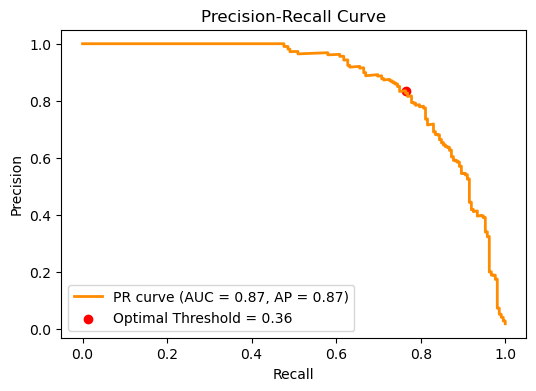

Optimal Threshold: 0.3621532903099461


In [205]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob[:, 1])

pr_auc = auc(recall, precision)
average_precision = average_precision_score(y_val, y_pred_prob[:, 1])

# Find the optimal point
fscore = (2 * precision * recall) / (precision + recall)
optimal_idx = np.argmax(fscore)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(6, 4))
plt.plot(
    recall,
    precision,
    color="darkorange",
    lw=2,
    label=f"PR curve (AUC = {pr_auc:.2f}, AP = {average_precision:.2f})",
)
plt.scatter(
    recall[optimal_idx],
    precision[optimal_idx],
    marker="o",
    color="red",
    label=f"Optimal Threshold = {optimal_threshold:.2f}",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

print(f"Optimal Threshold: {optimal_threshold}")

In [208]:
y_pred_prob = best_cat_boost.predict_proba(filtered_x_val)
threshold = 0.3621532903099461
y_pred_adjusted = (y_pred_prob[:, 1] >= threshold).astype(int)

By changing the decision probability threshold, we can reduce costs further.

In [209]:
-1 * cost_function(y_val, y_pred_adjusted)

29370

Our final evaluation result is 72% less costly than the baseline.

In [210]:
((106000 - 29370) / 106000) * 100

72.29245283018868

In [211]:
best_cat_boost.save_model("best_catboost_model.bin")

In [167]:
print(classification_report(y_val, best_cat_boost.predict_proba(scaled_val_data)))

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

# Confusion Matrix
We can check how it is comparing with the non-adjusted model.

In [ ]:
cm1 = confusion_matrix(y_val, y_pred)
cm2 = confusion_matrix(y_val, y_pred_adjusted)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("Adjusted Confusion Matrix")

plt.tight_layout()
plt.show()

# Model Calibration
We might want our model to output the probabilities that the predicted class is true. That could be useful when combined with human users who may want to make a better call if our model shows to be too near the decision boundary. 

predict_proba won't necessarely give us true probabilities, as the model may be miscalibrated. Let's check how our predict_proba compares to true probabilities and if we can improve it with some calibration. 

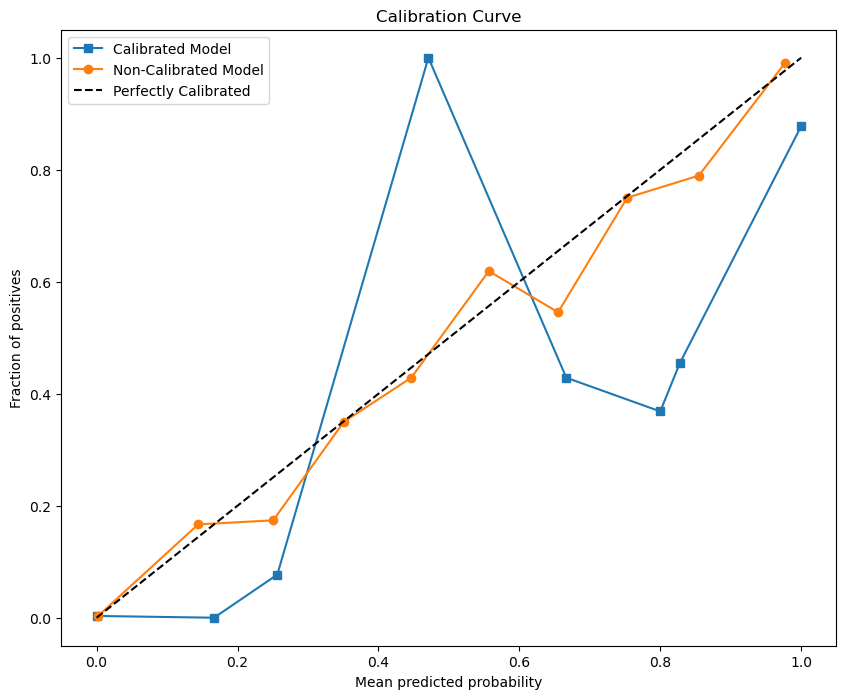

In [45]:
platt_calibrated = CalibratedClassifierCV(best_cat_boost, method="isotonic", cv="prefit")
platt_calibrated.fit(X_train, y_train)

calibrated_probabilities = platt_calibrated.predict_proba(X_val)
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_val, calibrated_probabilities[:, 1], n_bins=10
)
fraction_of_positives_non_cal, mean_predicted_value_non_cal = calibration_curve(
    y_val, best_cat_boost.predict_proba(X_val)[:, 1], n_bins=10
)

plt.figure(figsize=(10, 8))
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", label="Calibrated Model")
plt.plot(
    mean_predicted_value_non_cal,
    fraction_of_positives_non_cal,
    "o-",
    label="Non-Calibrated Model",
)
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

It turns out, our model is already well calibrated.

# Shap Values

In [138]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_cat_boost)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_val)

# Print the shapes for debugging
if isinstance(shap_values, list):
    print(f"Shapes of shap_values list: {[arr.shape for arr in shap_values]}")
else:
    print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of X_val: {X_val.shape}")
# # Plot summary of SHAP values for the test set
shap.summary_plot(shap_values, X_val)

NameError: name 'best_cat_boost' is not defined